In [1]:
import numpy as np
import csv
from tqdm import tqdm
import base64
from io import BytesIO
import requests
import io
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras import models
from keras.layers import Input,Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import tensorflow as tf
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from keras.regularizers import Regularizer
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Username of your GitHub account
username = ''

# Personal Access Token (PAO) from your GitHub account
token = ''

# Creates a re-usable session object with your creds in-built
github_session = requests.Session()
github_session.auth = (username, token)


In [4]:
url = 'https://raw.githubusercontent.com/OmdenaAI/WeoWater/main/task-3-wrangling-preprocessing/All_merged/All_data_sources_merged_updated.csv'
download = github_session.get(url).content #Reading and downloading the data
data = pd.read_csv(io.StringIO(download.decode('utf-8'))) #Converting the data into a pd dataframe

#Extract instagram data from all dataseources
twitter_data = data.loc[data['data source']=='Twitter']
twitter_data.to_csv('twitter_data.csv')

In [5]:
twitter_data = pd.read_csv('twitter_data.csv') 

In [6]:
twitter_data.head(5)

,Unnamed: 0,Id,title,time,keywords,data source,category,country,source URL,body,language
0,2465,1.550622e+09,NaN,2021-12-05 23:27:00+00:00,NaN,Twitter,flood,"Riverside, IA",NaN,RT @katiepeikes: Iowa scientists are developin...,English
1,2466,3.082977e+08,NaN,2021-12-05 23:23:00+00:00,NaN,Twitter,none,"West Des Moines, IA",NaN,RT @SenatorRobHogg: When @CityofCRIowa city co...,English
2,2467,2.296270e+07,NaN,2021-12-05 22:39:00+00:00,NaN,Twitter,flood,Somewhere in Iowa USA,NaN,Ames Flood mitigation project dusting off the ...,English
3,2468,1.340000e+18,NaN,2021-12-05 22:07:00+00:00,NaN,Twitter,flood,"Des Moines, Iowa",NaN,IWX extends time of Flood Warning for Maumee R...,English
4,2469,2.018772e+07,NaN,2021-12-05 21:47:00+00:00,NaN,Twitter,flood,"Cedar Rapids, Iowa",NaN,Flood control plans are well underway for the ...,English


In [7]:
twitter_data.shape

(1410, 11)

In [8]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1410 non-null   int64  
 1   Id           1410 non-null   float64
 2   title        0 non-null      float64
 3   time         1410 non-null   object 
 4   keywords     1149 non-null   object 
 5   data source  1410 non-null   object 
 6   category     1410 non-null   object 
 7   country      1410 non-null   object 
 8   source URL   1149 non-null   object 
 9   body         1410 non-null   object 
 10  language     1410 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 121.3+ KB


In [9]:
drop_columns = ['Unnamed: 0','title', 'time', 'keywords', 'data source', 'country', 'source URL', 'language', 'Id']
twitter_data_clean = twitter_data.drop(columns=drop_columns,axis=1)

In [10]:
twitter_data_clean.head(5)

,category,body
0,flood,RT @katiepeikes: Iowa scientists are developin...
1,none,RT @SenatorRobHogg: When @CityofCRIowa city co...
2,flood,Ames Flood mitigation project dusting off the ...
3,flood,IWX extends time of Flood Warning for Maumee R...
4,flood,Flood control plans are well underway for the ...


In [11]:
def preprocess(article):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the article
    text = article.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(posts) for posts in tqdm(twitter_data_clean['body'])]

100%|██████████| 1410/1410 [00:00<00:00, 35994.72it/s]


In [12]:
twitter_data_clean['Cleaned_body']= preprocessed

In [13]:
twitter_data_clean.head(5)

,category,body,Cleaned_body
0,flood,RT @katiepeikes: Iowa scientists are developin...,rt iowa scientists are developing tool to fore...
1,none,RT @SenatorRobHogg: When @CityofCRIowa city co...,rt when city council talks about planning and ...
2,flood,Ames Flood mitigation project dusting off the ...,ames flood mitigation project dusting off the ...
3,flood,IWX extends time of Flood Warning for Maumee R...,iwx extends time of flood warning for maumee r...
4,flood,Flood control plans are well underway for the ...,flood control plans are well underway for the ...


**Class balancing for category column**

In [14]:
twitter_data_clean.category.value_counts()

none                 725
flood                611
drought               43
flood_and_drought     31
Name: category, dtype: int64

In [15]:
twitter_data_flood = twitter_data_clean[twitter_data_clean.category == 'flood']
twitter_data_flood.shape

(611, 3)

In [16]:
twitter_data_none = twitter_data_clean[twitter_data_clean.category == 'none']
twitter_data_none.shape

(725, 3)

In [17]:
df_flood = shuffle(twitter_data_flood)
df_none = shuffle(twitter_data_none)

In [18]:
twitter_train_f= df_flood.head(500)
twitter_train_f.shape

(500, 3)

In [19]:
twitter_train_n= df_none.head(500)
twitter_train_n.shape

(500, 3)

In [20]:
twitter_test_f= df_flood.tail(111)
twitter_test_f.shape

(111, 3)

In [21]:
twitter_test_n= df_none.tail(111)
twitter_test_n.shape

(111, 3)

In [22]:
#concatenating
twitter_train =pd.concat([twitter_train_f,twitter_train_n], ignore_index=True)
twitter_train = shuffle(twitter_train)
twitter_train.shape

(1000, 3)

In [23]:
twitter_train.category.value_counts()

none     500
flood    500
Name: category, dtype: int64

In [24]:
#concatenating
twitter_test =pd.concat([twitter_test_f,twitter_test_n], ignore_index=True)
twitter_test = shuffle(twitter_test)
twitter_test.shape

(222, 3)

In [25]:
#changing the type from object to category
twitter_train['category']=twitter_train['category'].astype('category')
twitter_test['category']=twitter_test['category'].astype('category')

In [26]:
# Get the numerical ids of column label
numerical_ids_train = twitter_train.category.cat.codes
numerical_ids_test = twitter_test.category.cat.codes

# Print initial shape
print(numerical_ids_train.shape)
print(numerical_ids_test.shape)

(1000,)
(222,)


In [27]:
le = LabelEncoder()
Y = le.fit_transform(twitter_train['category'].values)
Y_test = le.transform(twitter_test['category'].values)
len(le.classes_)

2

In [28]:
# One-hot encode the indexes
Y = to_categorical(numerical_ids_train)
Y_test = to_categorical(numerical_ids_test)

# Check the new shape of the variable
print(Y.shape)
print(Y_test.shape)

# Print the first 5 rows
print(Y[:5])

(1000, 2)
(222, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


**NLP Modelling**

**fit_on_texts:** Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).


**texts_to_sequences:** Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(twitter_train.Cleaned_body)
# Create the (X, Y) variables
X = tokenizer.texts_to_sequences(twitter_train.Cleaned_body)
X = pad_sequences(X, maxlen=20)
#Y = to_categorical(twitter_train.category)
# Print the shapes
print(X.shape)
print(Y.shape)

(1000, 20)
(1000, 2)


In [30]:
X_test = tokenizer.texts_to_sequences(twitter_test.Cleaned_body)
X_test = pad_sequences(X_test, maxlen=20)
#Y_test = to_categorical(twitter_test.category)
print(X_test.shape)
print(Y_test.shape)

(222, 20)
(222, 2)


In [31]:
import pickle
with open("tokenizer_twitter_flood.pkl", 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)
with open("label_encoder_twitter_flood.pkl", 'wb') as file:
    pickle.dump(le, file, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 6000
EMBEDDING_DIM = 300
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5518 unique tokens.


In [33]:
EMBEDDING_FILE= '/content/gdrive/MyDrive/GoogleNews-vectors-negative300.bin.gz'

In [34]:
from gensim.models import KeyedVectors

print('Indexing word vectors')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE,binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Indexing word vectors
Found 3000000 word vectors of word2vec
Preparing embedding matrix
Null word embeddings: 1149


In [35]:
import numpy as np
np.save('embedding_matrix_twitter_flood.npy' , embedding_matrix)

In [36]:
from keras.optimizers import SGD,Adam
opt = SGD(learning_rate=0.01)
opt1= Adam(learning_rate=0.0001) 

In [37]:
model= Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
model.add(LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))
model.add(Dense(32,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer=opt1,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          1655700   
_________________________________________________________________
lstm (LSTM)                  (None, 230)               488520    
_________________________________________________________________
dense (Dense)                (None, 32)                7392      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 2,151,678
Trainable params: 495,978
Non-trainable params: 1,655,700
_________________________________________________________________


In [38]:
epochs= 8
batch_size= 12

history= model.fit(X,Y,epochs=epochs,batch_size=batch_size,validation_split=0.1)

Epoch 1/8
75/75 [==============================] - 27s 49ms/step - loss: 0.6850 - accuracy: 0.5717 - val_loss: 0.5964 - val_accuracy: 0.7800
Epoch 2/8
75/75 [==============================] - 3s 34ms/step - loss: 0.5673 - accuracy: 0.7553 - val_loss: 0.4339 - val_accuracy: 0.8200
Epoch 3/8
75/75 [==============================] - 3s 34ms/step - loss: 0.4605 - accuracy: 0.8091 - val_loss: 0.4246 - val_accuracy: 0.8200
Epoch 4/8
75/75 [==============================] - 2s 32ms/step - loss: 0.4198 - accuracy: 0.8329 - val_loss: 0.4313 - val_accuracy: 0.8100
Epoch 5/8
75/75 [==============================] - 2s 32ms/step - loss: 0.3780 - accuracy: 0.8393 - val_loss: 0.3885 - val_accuracy: 0.8200
Epoch 6/8
75/75 [==============================] - 2s 32ms/step - loss: 0.3731 - accuracy: 0.8510 - val_loss: 0.3922 - val_accuracy: 0.8300
Epoch 7/8
75/75 [==============================] - 2s 33ms/step - loss: 0.3079 - accuracy: 0.8688 - val_loss: 0.4089 - val_accuracy: 0.8300
Epoch 8/8
75/75 [==

Text(0.5, 1.0, 'Loss')

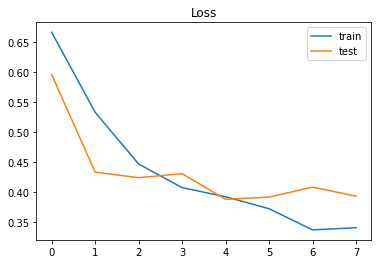

In [39]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Accuracy')

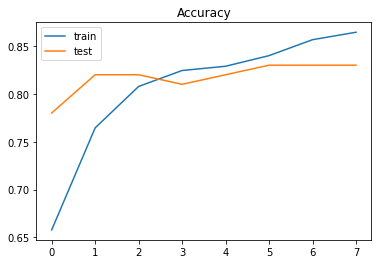

In [40]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

**Predicting Data**

In [41]:
y_pred = model.predict(X_test)

In [42]:
import numpy as np
y_pred=np.round(y_pred)

In [43]:
y_pred = np.argmax(y_pred, axis=-1)

In [44]:
y_test = np.argmax(Y_test, axis=-1)

In [45]:
y_pred

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1])

In [46]:
# Accuracy
print(accuracy_score(y_test, y_pred))

0.8513513513513513


In [47]:
lab_names = ['flood','none']
print(classification_report(y_test, y_pred, target_names=lab_names))

              precision    recall  f1-score   support

       flood       0.84      0.87      0.85       111
        none       0.87      0.83      0.85       111

    accuracy                           0.85       222
   macro avg       0.85      0.85      0.85       222
weighted avg       0.85      0.85      0.85       222



In [48]:
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))
print(f1_score(y_test, y_pred, average=None))

[0.8362069  0.86792453]
[0.87387387 0.82882883]
[0.85462555 0.84792627]


In [49]:
model.save('LSTMClassifier_with_twitter_flood.h5')